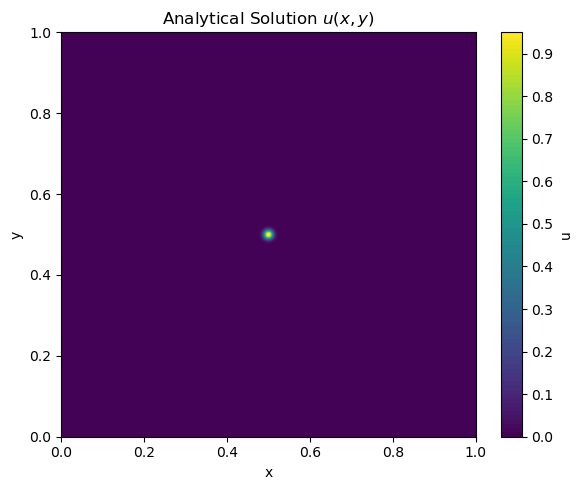

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Domain
x = np.linspace(0, 1, 300)
y = np.linspace(0, 1, 300)
X, Y = np.meshgrid(x, y)

# Parameters for the Gaussian bump
x0, y0 = 0.5, 0.5
sigma = 0.01

# Analytical solution
U = np.exp(-((X - x0)**2 + (Y - y0)**2) / sigma**2)

# RHS of the Poisson equation: f(x, y) = -Delta u
f = ((4 * ((X - x0)**2 + (Y - y0)**2) - 4 * sigma**2) / sigma**4) * U

# Plotting the analytical solution
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, U, levels=100, cmap='viridis')
plt.title('Analytical Solution $u(x, y)$')
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()


In [43]:
import deepxde as dde
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Domain bounds
geom = dde.geometry.Rectangle([0, 0], [1, 1])
soft_boundary = False  # Set to True for soft boundary condition

# Gaussian parameters
# x0, y0 = 0.5, 0.5
# sigma = 0.05

# Analytical solution u(x, y)
def u_true(x):
    return jnp.exp(-((x[:, 0] - x0) ** 2 + (x[:, 1] - y0) ** 2) / sigma**2).reshape(-1, 1)

# Source term f(x, y) = -Δu(x, y)
def f(x):
    r2 = (x[:, 0] - x0) ** 2 + (x[:, 1] - y0) ** 2
    return (
        ((4 * r2 - 4 * sigma**2) / sigma**4)
        * jnp.exp(-r2 / sigma**2)
    ).reshape(-1, 1)

# PDE definition
def pde(x, u):
    du_xx = dde.grad.hessian(u, x, i=0, j=0)[0]
    du_yy = dde.grad.hessian(u, x, i=1, j=1)[0]
    return -(du_xx + du_yy) + f(x)

# Boundary condition
def boundary(x, on_boundary):
    return on_boundary

bc = dde.DirichletBC(geom, u_true, boundary, component=0) if soft_boundary else []

# bc = dde.DirichletBC(geom, u_true, boundary)

def hard_boundary(x, f):
    f = f * x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return f

# Geometry and PDE problem
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=10000,
    num_boundary=2000,
    solution=u_true,
    num_test=10000,
)

# Model: plain feedforward net (MLP) without Fourier features
net = dde.nn.FNN([50] * 4 + [1], "tanh", "Glorot normal")

if not soft_boundary:
    # Apply hard boundary condition
    net.apply_output_transform(hard_boundary)

model = dde.Model(data, net)

In [44]:
# Compile & Train
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=50000)

Compiling model...
'compile' took 0.177407 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [7.74e+04]    [8.37e+04]    [1.34e+00]    
1000      [9.60e+03]    [7.22e+04]    [9.94e+00]    
2000      [1.87e+03]    [5.05e+04]    [7.95e+00]    
3000      [1.23e+03]    [4.58e+04]    [4.45e+00]    
4000      [8.37e+02]    [4.50e+04]    [3.41e+00]    
5000      [4.56e+02]    [4.67e+04]    [3.06e+00]    
6000      [6.48e+02]    [4.07e+04]    [2.93e+00]    
7000      [3.24e+02]    [4.38e+04]    [2.69e+00]    
8000      [3.51e+02]    [4.34e+04]    [2.34e+00]    
9000      [2.18e+02]    [4.12e+04]    [1.95e+00]    
10000     [1.59e+03]    [3.60e+04]    [1.80e+00]    
11000     [1.83e+02]    [4.11e+04]    [1.81e+00]    
12000     [6.37e+02]    [4.23e+04]    [1.75e+00]    
13000     [1.33e+02]    [4.24e+04]    [1.90e+00]    
14000     [1.37e+02]    [4.05e+04]    [1.82e+00]    
15000     [1.28e+02]    [4.16e+04]    [1.83e+00]    
16000     [1.34e+02]    [4.17e+04]

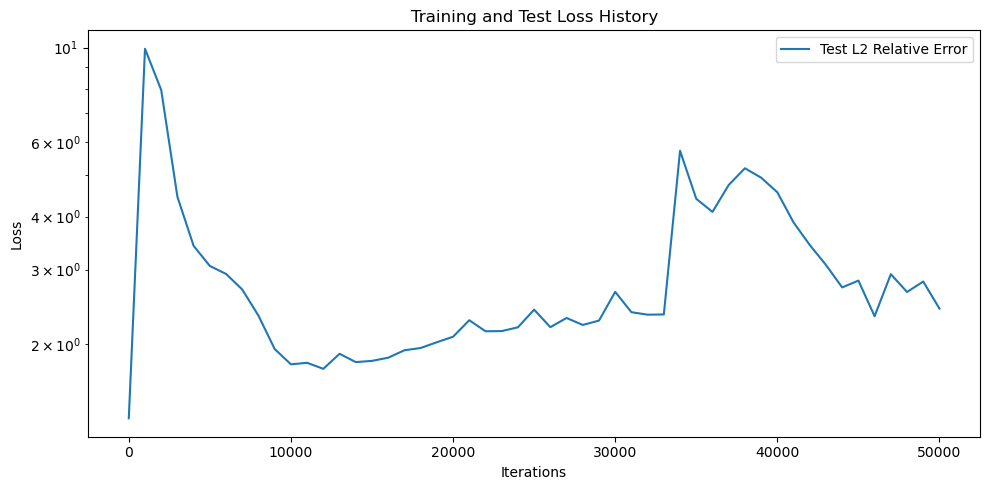

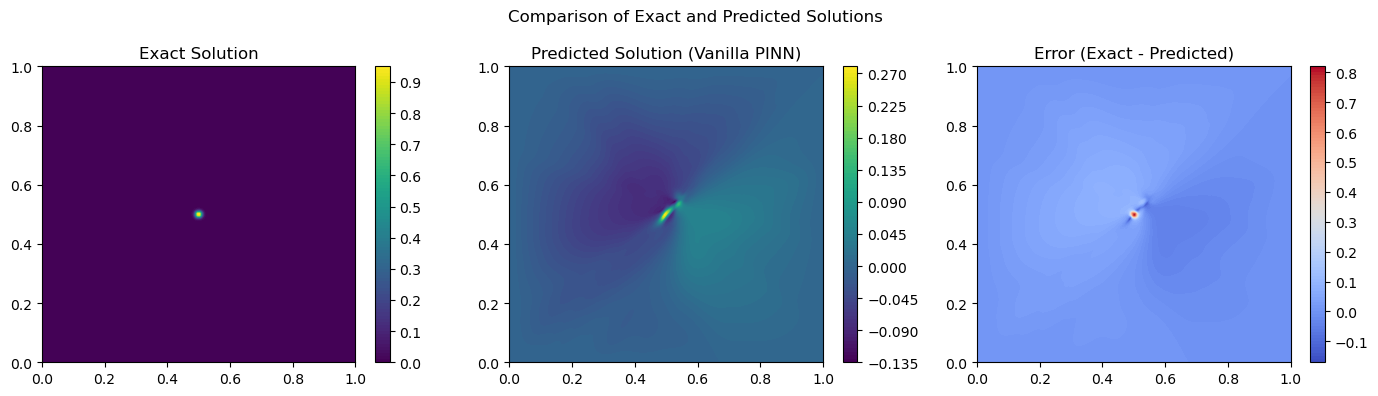

In [45]:
# Plot prediction vs ground truth
X, Y = np.meshgrid(np.linspace(0, 1, 300), np.linspace(0, 1, 300))
XY = np.vstack((X.flatten(), Y.flatten())).T
u_pred = model.predict(XY).reshape(300, 300)
u_exact = u_true(XY).reshape(300, 300)

# Plotting loss history
plt.figure(figsize=(10, 5))
# plt.plot(losshistory.loss_train, label="Training Loss")
# plt.plot(losshistory.loss_test.sum(axis=1), label="Test Loss")
plt.plot(losshistory.steps,losshistory.metrics_test, label="Test L2 Relative Error")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training and Test Loss History")
plt.legend()
plt.tight_layout()
plt.show()

# Plotting the exact solution, predicted solution, and error
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.contourf(X, Y, u_exact, 100, cmap="viridis")
plt.colorbar()
plt.title("Exact Solution")

plt.subplot(1, 3, 2)
plt.contourf(X, Y, u_pred, 100, cmap="viridis")
plt.colorbar()
plt.title("Predicted Solution (Vanilla PINN)")

plt.subplot(1, 3, 3)
plt.contourf(X, Y, u_exact - u_pred, 100, cmap="coolwarm")
plt.colorbar()
plt.title("Error (Exact - Predicted)")
plt.suptitle("Comparison of Exact and Predicted Solutions")
plt.tight_layout()
plt.show()

In [46]:
import jax

# Model: plain feedforward net (MLP) without Fourier features
def fourier_features(x, sigma=10, num_features=100):
    """Generate Fourier features for input x."""
    kernel = jax.random.normal(
        jax.random.PRNGKey(0), (x.shape[-1], num_features)
    ) * sigma
    y = jnp.concatenate(
        [jnp.cos(jnp.dot(x, kernel)), jnp.sin(jnp.dot(x, kernel))], axis=-1
    )
    return y


net = dde.nn.FNN([50] * 4 + [1], "tanh", "Glorot normal")

net.apply_feature_transform(fourier_features)  # Apply Fourier features transform
net.apply_output_transform(hard_boundary)  # Apply hard boundary condition

model = dde.Model(data, net)

In [47]:
# Compile & Train
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory_fourier, train_state_fourier = model.train(iterations=50000)

Compiling model...
'compile' took 1.048097 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [7.75e+04]    [8.38e+04]    [2.22e+00]    
1000      [2.86e+02]    [7.86e+04]    [2.73e+00]    
2000      [8.58e+02]    [9.17e+04]    [3.36e+00]    
3000      [7.73e+02]    [9.47e+04]    [2.40e+00]    
4000      [5.82e+02]    [9.62e+04]    [1.83e+00]    
5000      [3.87e+02]    [9.37e+04]    [1.60e+00]    
6000      [1.18e+02]    [7.26e+04]    [2.05e+00]    
7000      [1.47e+02]    [7.45e+04]    [1.58e+00]    
8000      [1.33e+02]    [7.56e+04]    [1.45e+00]    
9000      [1.57e+03]    [8.74e+04]    [3.47e+00]    
10000     [4.56e+02]    [8.93e+04]    [2.49e+00]    
11000     [3.15e+02]    [8.83e+04]    [2.04e+00]    
12000     [3.03e+02]    [8.36e+04]    [1.77e+00]    
13000     [2.18e+02]    [7.93e+04]    [1.59e+00]    
14000     [1.43e+02]    [8.19e+04]    [1.98e+00]    
15000     [1.52e+02]    [7.68e+04]    [1.33e+00]    
16000     [1.65e+02]    [7.45e+04]

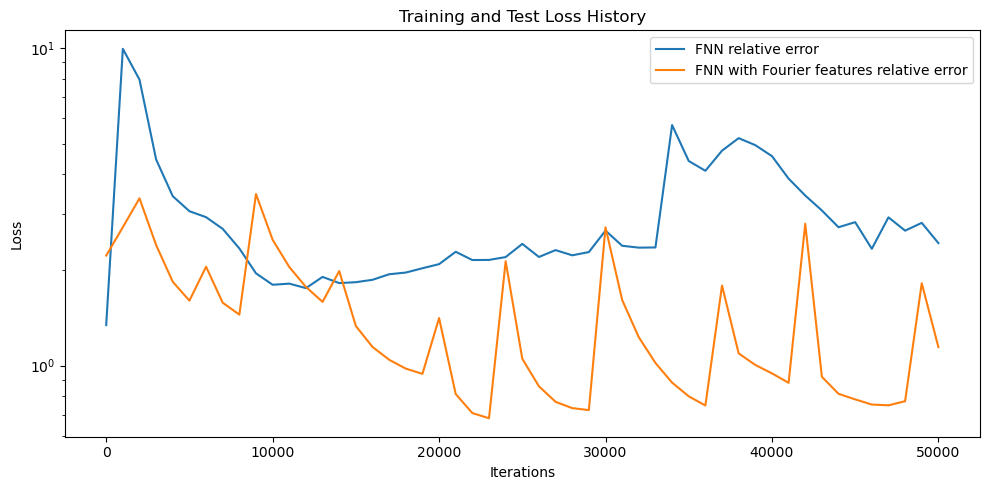

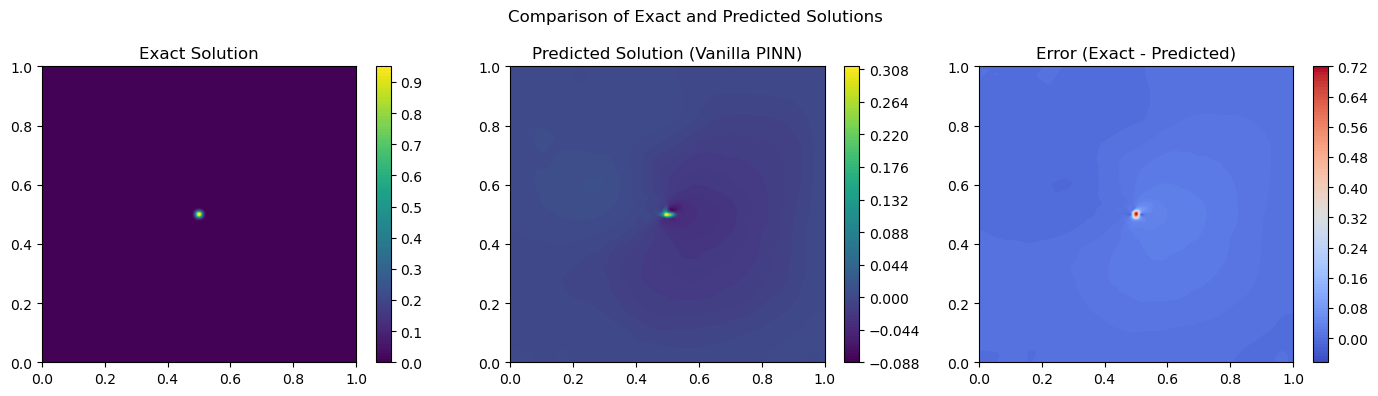

In [48]:
# Plot prediction vs ground truth
X, Y = np.meshgrid(np.linspace(0, 1, 300), np.linspace(0, 1, 300))
XY = np.vstack((X.flatten(), Y.flatten())).T
u_pred = model.predict(XY).reshape(300, 300)
u_exact = u_true(XY).reshape(300, 300)


# Plotting loss history
plt.figure(figsize=(10, 5))
# plt.plot(losshistory.loss_train, label="Training Loss")
# plt.plot(losshistory.loss_test.sum(axis=1), label="Test Loss")
plt.plot(losshistory.steps, losshistory.metrics_test, label="FNN relative error")
plt.plot(losshistory_fourier.steps, losshistory_fourier.metrics_test, label="FNN with Fourier features relative error")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training and Test Loss History")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.contourf(X, Y, u_exact, 100, cmap="viridis")
plt.colorbar()
plt.title("Exact Solution")

plt.subplot(1, 3, 2)
plt.contourf(X, Y, u_pred, 100, cmap="viridis")
plt.colorbar()
plt.title("Predicted Solution (Vanilla PINN)")

plt.subplot(1, 3, 3)
contour = plt.contourf(X, Y, u_exact - u_pred, 100, cmap="coolwarm")
plt.colorbar()
plt.title("Error (Exact - Predicted)")
plt.suptitle("Comparison of Exact and Predicted Solutions")
plt.tight_layout()
plt.show()

In [49]:
def transform_coords(x):
    """
    For SPINN, if the input x is provided as a list of 1D arrays (e.g., [X_coords, Y_coords]),
    this function creates a 2D meshgrid and stacks the results into a 2D coordinate array.
    """
    x_mesh = [x_.ravel() for x_ in jnp.meshgrid(jnp.atleast_1d(x[0].squeeze()), jnp.atleast_1d(x[1].squeeze()), indexing="ij")]
    return dde.backend.stack(x_mesh, axis=-1)

# Analytical solution u(x, y)
def u_true(x):
    if isinstance(x, list):
        x = transform_coords(x)
    return jnp.exp(-((x[:, 0] - x0) ** 2 + (x[:, 1] - y0) ** 2) / sigma**2).reshape(-1, 1)


def pde(x, u):
    """
    Define the PDE residuals for the linear elastic plate.
    """
    x = transform_coords(x)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)[0]
    du_yy = dde.grad.hessian(u, x, i=1, j=1)[0]
    return -(du_xx + du_yy) + f(x)

def HardBC(x, f):
    """
    Apply hard boundary conditions via transformation.
    If x is provided as a list of 1D arrays, transform it to a 2D meshgrid.
    """
    if isinstance(x, list):
        x = transform_coords(x)
    f = f * x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return f

# Geometry and PDE problem
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=40000,
    num_boundary=0,
    solution=u_true,
    num_test=10000,
    is_SPINN=True,  # Set to True for SPINN
)

net = dde.nn.SPINN([2] + [50] * 4 + [1], "tanh", "Glorot normal")

# net.apply_feature_transform(fourier_features)  # Apply Fourier features transform
net.apply_output_transform(HardBC)  # Apply hard boundary condition

model = dde.Model(data, net)

In [50]:
# Compile & Train
model.compile("adam", lr=5e-4, metrics=["l2 relative error"])
losshistory_spinn, train_state_spinn = model.train(iterations=20000)

Compiling model...
'compile' took 0.130514 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.27e+05]    [8.37e+04]    [1.01e+00]    
1000      [3.97e+02]    [4.18e+02]    [4.33e-01]    
2000      [9.25e+01]    [1.54e+02]    [1.93e-01]    
3000      [2.64e+01]    [1.11e+02]    [1.70e-01]    
4000      [8.44e+01]    [1.64e+02]    [1.57e-01]    
5000      [2.29e+01]    [8.93e+01]    [1.46e-01]    
6000      [7.88e+00]    [6.97e+01]    [1.35e-01]    
7000      [4.00e+01]    [1.07e+02]    [1.29e-01]    
8000      [5.63e+00]    [5.53e+01]    [1.15e-01]    
9000      [4.44e+01]    [1.15e+02]    [1.10e-01]    
10000     [1.52e+02]    [2.54e+02]    [1.31e-01]    
11000     [2.98e+01]    [7.84e+01]    [9.94e-02]    
12000     [4.12e+01]    [8.59e+01]    [9.28e-02]    
13000     [6.23e+00]    [4.66e+01]    [8.23e-02]    
14000     [1.19e+01]    [5.09e+01]    [7.57e-02]    
15000     [8.38e+00]    [5.02e+01]    [7.54e-02]    
16000     [6.24e+00]    [4.36e+01]

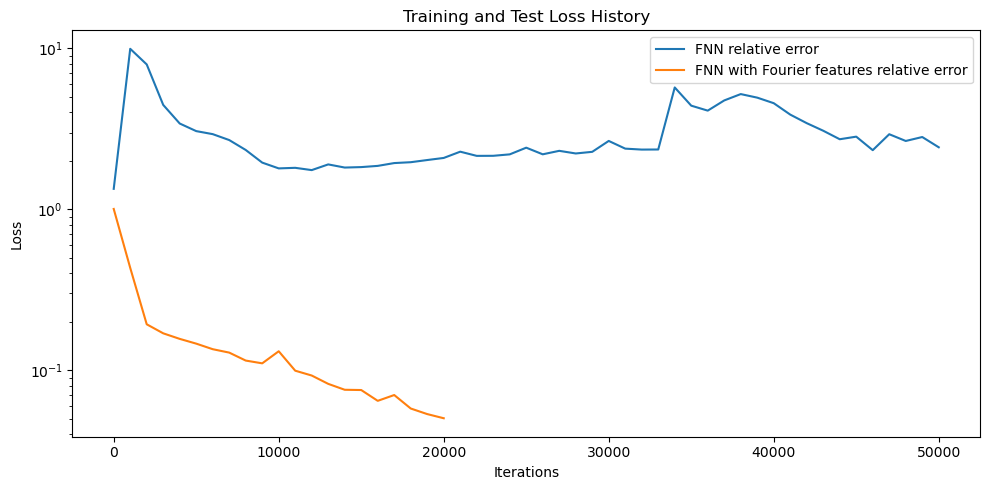

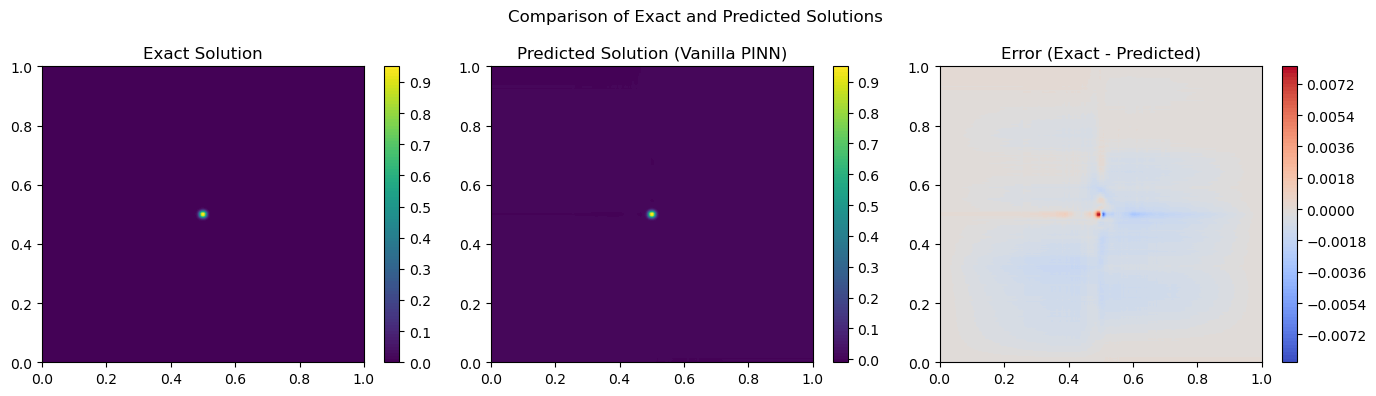

In [51]:
# Plot prediction vs ground truth
X, Y = np.meshgrid(np.linspace(0, 1, 300), np.linspace(0, 1, 300))
XY = np.vstack((X.flatten(), Y.flatten())).T
u_pred = model.predict([[np.linspace(0, 1, 300).reshape(-1,1)]*2]).reshape(300, 300)
u_exact = u_true(XY).reshape(300, 300)


# Plotting loss history
plt.figure(figsize=(10, 5))
# plt.plot(losshistory.loss_train, label="Training Loss")
# plt.plot(losshistory.loss_test.sum(axis=1), label="Test Loss")
plt.plot(losshistory.steps, losshistory.metrics_test, label="FNN relative error")
plt.plot(losshistory_spinn.steps, losshistory_spinn.metrics_test, label="FNN with Fourier features relative error")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training and Test Loss History")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.contourf(X, Y, u_exact, 100, cmap="viridis")
plt.colorbar()
plt.title("Exact Solution")

plt.subplot(1, 3, 2)
plt.contourf(X, Y, u_pred, 100, cmap="viridis")
plt.colorbar()
plt.title("Predicted Solution (Vanilla PINN)")

plt.subplot(1, 3, 3)
contour = plt.contourf(X, Y, u_exact - u_pred, 100, cmap="coolwarm")
plt.colorbar()
plt.title("Error (Exact - Predicted)")
plt.suptitle("Comparison of Exact and Predicted Solutions")
plt.tight_layout()
plt.show()

In [ ]:


# Geometry and PDE problem
n_pde = 100
x_full = np.linspace(0, 1, n_pde).reshape(-1, 1)
y_full = np.linspace(0, 1, n_pde).reshape(-1, 1)

x_middle = np.linspace(0.45, 0.55, n_pde).reshape(-1, 1)
y_middle = np.linspace(0.45, 0.55, n_pde).reshape(-1, 1)



geom = dde.geometry.ListPointCloud([[x_full, y_full], 
                                    [x_middle, y_middle]])

data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=40000,
    num_boundary=0,
    solution=u_true,
    num_test=10000,
    is_SPINN=True,  # Set to True for SPINN
)

model = dde.Model(data, net)

In [52]:
# Compile & Train
model.compile("adam", lr=5e-4, metrics=["l2 relative error"])
losshistory_spinn_adapt, train_state_spinn_adapt = model.train(iterations=20000)

Compiling model...
'compile' took 0.096454 s

Training model...

Step      Train loss    Test loss     Test metric   
20000     [1.98e+01]    [4.69e+01]    [5.03e-02]    
21000     [2.00e+00]    [3.23e+01]    [4.99e-02]    
22000     [6.84e+00]    [3.83e+01]    [4.67e-02]    
23000     [2.09e+00]    [2.91e+01]    [4.70e-02]    
24000     [4.65e+00]    [3.12e+01]    [4.64e-02]    
25000     [8.00e+00]    [2.92e+01]    [4.08e-02]    
26000     [1.74e+00]    [2.83e+01]    [3.74e-02]    
27000     [2.73e+00]    [2.63e+01]    [3.83e-02]    
28000     [1.13e+02]    [1.81e+02]    [8.13e-02]    
29000     [1.01e+01]    [3.67e+01]    [3.44e-02]    
30000     [4.85e+00]    [3.04e+01]    [2.99e-02]    
31000     [5.52e+00]    [2.96e+01]    [4.33e-02]    
32000     [2.04e+01]    [4.71e+01]    [2.86e-02]    
33000     [8.40e+00]    [3.23e+01]    [2.69e-02]    
34000     [1.90e+01]    [4.58e+01]    [2.98e-02]    
35000     [5.09e+01]    [8.91e+01]    [4.50e-02]    
36000     [7.48e+01]    [1.20e+02]

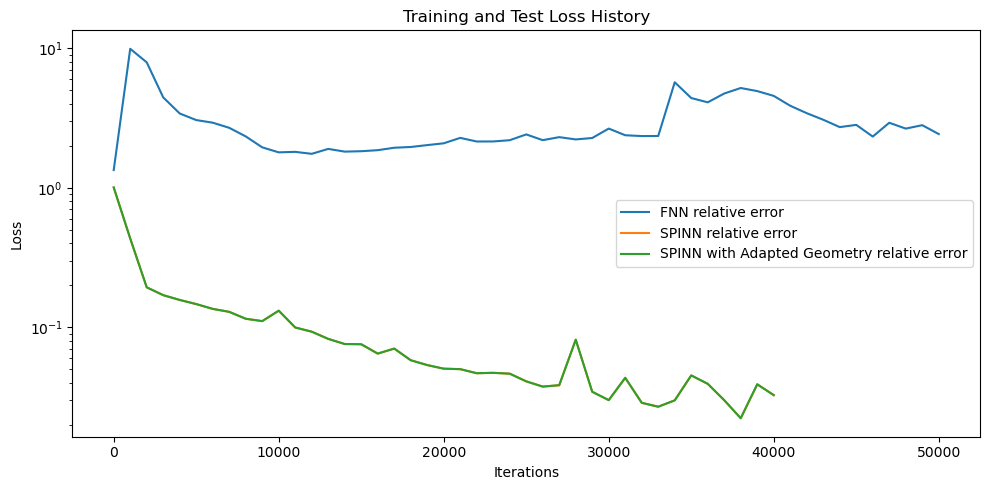

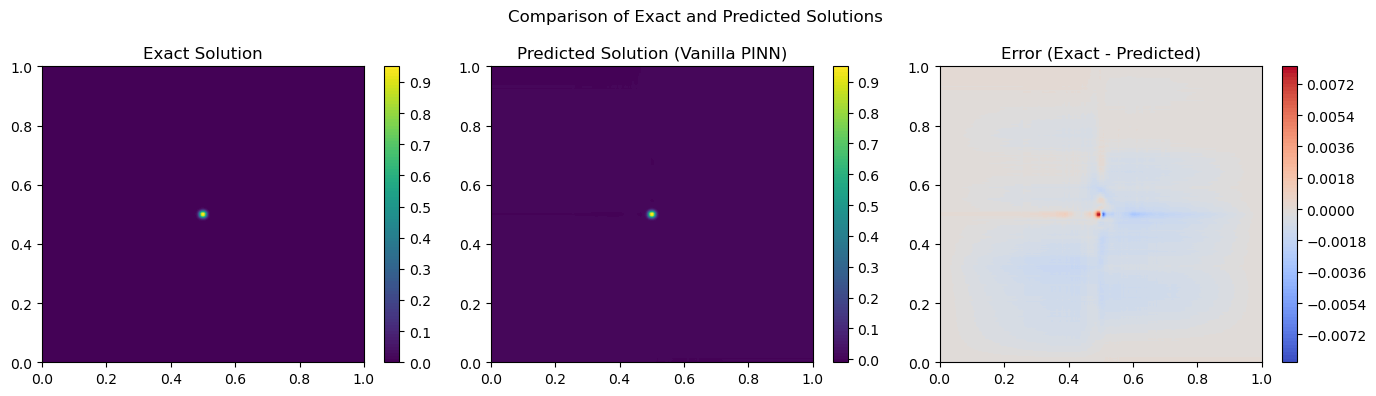

In [53]:
# Plotting loss history
plt.figure(figsize=(10, 5))
# plt.plot(losshistory.loss_train, label="Training Loss")
# plt.plot(losshistory.loss_test.sum(axis=1), label="Test Loss")
plt.plot(losshistory.steps, losshistory.metrics_test, label="FNN relative error")
plt.plot(losshistory_spinn.steps, losshistory_spinn.metrics_test, label="SPINN relative error")
plt.plot(losshistory_spinn_adapt.steps, losshistory_spinn_adapt.metrics_test, label="SPINN with Adapted Geometry relative error")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training and Test Loss History")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.contourf(X, Y, u_exact, 100, cmap="viridis")
plt.colorbar()
plt.title("Exact Solution")

plt.subplot(1, 3, 2)
plt.contourf(X, Y, u_pred, 100, cmap="viridis")
plt.colorbar()
plt.title("Predicted Solution (Vanilla PINN)")

plt.subplot(1, 3, 3)
contour = plt.contourf(X, Y, u_exact - u_pred, 100, cmap="coolwarm")
plt.colorbar()
plt.title("Error (Exact - Predicted)")
plt.suptitle("Comparison of Exact and Predicted Solutions")
plt.tight_layout()
plt.show()